In [1]:
import os
import h5py
import librosa
import itertools
import keras
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications.resnet50 import preprocess_input, ResNet50

In [3]:
os.getcwd()

'C:\\Users\\sai krishna\\music 1'

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis] #keep n_mels=128. other values are for experimenting

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [6]:
def split_convert(X, y):
    arr_spec, arr_genre = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre, window=0.05) #keep window=0.05. Other values are for experimenting. 

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genre.extend(y)
        arr_spec.extend(specs)
    
    return np.array(arr_spec), to_categorical(arr_genre)

In [7]:
def read_data(src_dir, genres, song_samples,get_data='train'):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    if get_data=='train':
        for x,_ in genres.items():
            folder = src_dir+'/'+'train'+'/' + x
            for root, subdirs, files in os.walk(folder):
                for file in files:
                    file_name = folder + "/" + file

                    # Save the file name and the genre
                    arr_fn.append(file_name)
                    arr_genres.append(genres[x])
        
        # Split into small segments and convert to spectrogram
        X_train, y_train = split_convert(arr_fn, arr_genres)
        return X_train, y_train
    
    elif get_data=='test':
        folder = src_dir+'/'+'test'
        for root, subdirs, files in os.walk(folder):
            for idx,file in enumerate(files):
                file_name = folder + "/" + file
                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(idx//10)
    
        X_test, y_test = split_convert(arr_fn, arr_genres)
        return X_test, y_test
    else:
        #print('Specify "test" or "train"')
        return None,None

In [8]:
# Parameters
dataset = 'genres'
song_samples = 660000
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, y_train = read_data(dataset, genres, song_samples,get_data='train')
X_test, y_test = read_data(dataset, genres, song_samples,get_data='test')

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(39000, 128, 129, 1) (3900, 128, 129, 1) (39000, 10) (3900, 10)


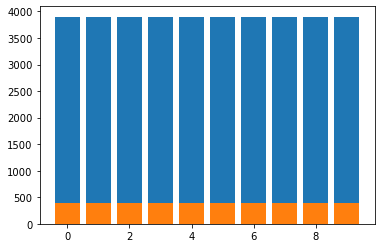

In [10]:
 # Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [11]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=2)
                cols = np.random.randint(signal.shape[0], size=3)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

In [12]:
def conv_block(x, n_filters,filter_size=(3, 3), pool_size=(2, 2),stride=(1, 1)):
    x = Conv2D(n_filters, filter_size, strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=stride)(x)
    x = Dropout(0.4)(x)
    return x

In [13]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16,stride=(2,2))
    x = conv_block(x, 32,filter_size=(3,3),stride=(2,2))
    x = conv_block(x, 64, stride=(2,2))
    x = conv_block(x, 128,filter_size=(3,3),stride=(2,2))
    x = conv_block(x, 256,stride=(2,2))

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [14]:
model = create_model(X_train[0].shape, 10)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 129, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 129, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 128, 129, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0     

In [16]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [17]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.97,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-10
)

In [18]:
# Generators
batch_size = 128
train_generator = DataGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = DataGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [19]:
hist = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=500,
    verbose=1,
    callbacks=[reduceLROnPlat])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 305.0 steps, validate for 31.0 steps
Epoch 1/500
305/305 [==============================] - 78s 257ms/step - loss: 4.8060 - accuracy: 0.1121 - val_loss: 3.5913 - val_accuracy: 0.1855
Epoch 2/500
305/305 [==============================] - 54s 178ms/step - loss: 3.1693 - accuracy: 0.1394 - val_loss: 2.9505 - val_accuracy: 0.2515
Epoch 3/500
305/305 [==============================] - 52s 172ms/step - loss: 2.7024 - accuracy: 0.1894 - val_loss: 2.6022 - val_accuracy: 0.2757
Epoch 4/500
305/305 [==============================] - 53s 173ms/step - loss: 2.4597 - accuracy: 0.1924 - val_loss: 2.5173 - val_accuracy: 0.2147
Epoch 5/500
305/305 [==============================] - 53s 174ms/step - loss: 2.3184 - accuracy: 0.1803 - val_loss: 2.2014 - val_accuracy: 0.4239
Epoch 6/500
305/305 [==============================] - 53s 174ms/step - loss: 2.2411 - accuracy: 0.1947 - val_loss: 2.1444 - val_accuracy: 0.3659
Epoch 7/500
305/305 [======

Epoch 48/500
305/305 [==============================] - 61s 200ms/step - loss: 1.5732 - accuracy: 0.4717 - val_loss: 1.4499 - val_accuracy: 0.5091
Epoch 49/500
305/305 [==============================] - 63s 206ms/step - loss: 1.5021 - accuracy: 0.4997 - val_loss: 1.3160 - val_accuracy: 0.5781
Epoch 50/500
305/305 [==============================] - 63s 206ms/step - loss: 1.5411 - accuracy: 0.4901 - val_loss: 1.4558 - val_accuracy: 0.4612
Epoch 51/500
305/305 [==============================] - 54s 176ms/step - loss: 1.5452 - accuracy: 0.4989 - val_loss: 1.3939 - val_accuracy: 0.5701
Epoch 52/500
305/305 [==============================] - 64s 208ms/step - loss: 1.5302 - accuracy: 0.4895 - val_loss: 1.2325 - val_accuracy: 0.6421
Epoch 53/500
305/305 [==============================] - 64s 209ms/step - loss: 1.5116 - accuracy: 0.5001 - val_loss: 1.3382 - val_accuracy: 0.5514
Epoch 54/500
305/305 [==============================] - 62s 202ms/step - loss: 1.5099 - accuracy: 0.5075 - val_loss: 1

Epoch 95/500
305/305 [==============================] - 63s 207ms/step - loss: 1.3426 - accuracy: 0.5737 - val_loss: 1.1358 - val_accuracy: 0.6608
Epoch 96/500
304/305 [============================>.] - ETA: 0s - loss: 1.2730 - accuracy: 0.5937 ETA: 1s - loss: 1.2746 - accuracy
Epoch 00096: ReduceLROnPlateau reducing learning rate to 0.0006142536766128615.
305/305 [==============================] - 63s 208ms/step - loss: 1.2707 - accuracy: 0.5944 - val_loss: 1.0926 - val_accuracy: 0.6628
Epoch 97/500
305/305 [==============================] - 66s 217ms/step - loss: 1.2447 - accuracy: 0.6064 - val_loss: 1.1214 - val_accuracy: 0.6759
Epoch 98/500
305/305 [==============================] - 65s 212ms/step - loss: 1.2980 - accuracy: 0.5782 - val_loss: 1.0634 - val_accuracy: 0.6779
Epoch 99/500
305/305 [==============================] - 67s 219ms/step - loss: 1.2552 - accuracy: 0.6007 - val_loss: 1.0701 - val_accuracy: 0.6709
Epoch 100/500
304/305 [============================>.] - ETA: 0s -

304/305 [============================>.] - ETA: 0s - loss: 1.1713 - accuracy: 0.6326
Epoch 00140: ReduceLROnPlateau reducing learning rate to 0.00046697473939275367.
305/305 [==============================] - 62s 205ms/step - loss: 1.1715 - accuracy: 0.6325 - val_loss: 0.9379 - val_accuracy: 0.7238
Epoch 141/500
305/305 [==============================] - 64s 210ms/step - loss: 1.1194 - accuracy: 0.6525 - val_loss: 0.8630 - val_accuracy: 0.7399
Epoch 142/500
305/305 [==============================] - 70s 231ms/step - loss: 1.0940 - accuracy: 0.6621 - val_loss: 0.8101 - val_accuracy: 0.7762
Epoch 143/500
305/305 [==============================] - 61s 201ms/step - loss: 1.1223 - accuracy: 0.6505 - val_loss: 0.8236 - val_accuracy: 0.7515
Epoch 144/500
305/305 [==============================] - 66s 215ms/step - loss: 1.0975 - accuracy: 0.6667 - val_loss: 0.9702 - val_accuracy: 0.6996
Epoch 145/500
304/305 [============================>.] - ETA: 0s - loss: 1.1019 - accuracy: 0.6600
Epoch 001

Epoch 184/500
305/305 [==============================] - 67s 219ms/step - loss: 1.0405 - accuracy: 0.6779 - val_loss: 1.0011 - val_accuracy: 0.7041
Epoch 185/500
305/305 [==============================] - 66s 216ms/step - loss: 1.0166 - accuracy: 0.6820 - val_loss: 0.8809 - val_accuracy: 0.7409
Epoch 186/500
305/305 [==============================] - 63s 208ms/step - loss: 1.0272 - accuracy: 0.6829 - val_loss: 0.7538 - val_accuracy: 0.7979
Epoch 187/500
304/305 [============================>.] - ETA: 0s - loss: 0.9692 - accuracy: 0.7017
Epoch 00187: ReduceLROnPlateau reducing learning rate to 0.0003340276895323768.
305/305 [==============================] - 64s 210ms/step - loss: 0.9737 - accuracy: 0.6998 - val_loss: 0.7661 - val_accuracy: 0.7848
Epoch 188/500
305/305 [==============================] - 64s 210ms/step - loss: 0.9823 - accuracy: 0.6964 - val_loss: 0.8802 - val_accuracy: 0.7424
Epoch 189/500
305/305 [==============================] - 71s 232ms/step - loss: 0.9741 - accura

305/305 [==============================] - 66s 215ms/step - loss: 0.8780 - accuracy: 0.7278 - val_loss: 0.5813 - val_accuracy: 0.8412
Epoch 274/500
305/305 [==============================] - 76s 248ms/step - loss: 0.8970 - accuracy: 0.7247 - val_loss: 0.5857 - val_accuracy: 0.8362
Epoch 275/500
304/305 [============================>.] - ETA: 0s - loss: 0.8237 - accuracy: 0.7436
Epoch 00275: ReduceLROnPlateau reducing learning rate to 0.00018726019407040438.
305/305 [==============================] - 70s 231ms/step - loss: 0.8224 - accuracy: 0.7442 - val_loss: 0.6179 - val_accuracy: 0.8191
Epoch 276/500
305/305 [==============================] - 65s 212ms/step - loss: 0.8635 - accuracy: 0.7304 - val_loss: 0.6590 - val_accuracy: 0.8070
Epoch 277/500
305/305 [==============================] - 65s 213ms/step - loss: 0.8801 - accuracy: 0.7283 - val_loss: 0.5872 - val_accuracy: 0.8412
Epoch 278/500
305/305 [==============================] - 64s 211ms/step - loss: 0.8990 - accuracy: 0.7204 - 

305/305 [==============================] - 59s 192ms/step - loss: 0.8090 - accuracy: 0.7459 - val_loss: 0.5445 - val_accuracy: 0.8448
Epoch 361/500
305/305 [==============================] - 63s 206ms/step - loss: 0.7947 - accuracy: 0.7521 - val_loss: 0.5548 - val_accuracy: 0.8387
Epoch 362/500
304/305 [============================>.] - ETA: 0s - loss: 0.8421 - accuracy: 0.7355 - ETA: 14s - loss:  -
Epoch 00362: ReduceLROnPlateau reducing learning rate to 9.87760977295693e-05.
305/305 [==============================] - 66s 215ms/step - loss: 0.8426 - accuracy: 0.7352 - val_loss: 0.5595 - val_accuracy: 0.8377
Epoch 363/500
305/305 [==============================] - 64s 209ms/step - loss: 0.7635 - accuracy: 0.7649 - val_loss: 0.5066 - val_accuracy: 0.8564
Epoch 364/500
305/305 [==============================] - 64s 209ms/step - loss: 0.7866 - accuracy: 0.7554 - val_loss: 0.5207 - val_accuracy: 0.8463
Epoch 365/500
305/305 [==============================] - 63s 207ms/step - loss: 0.7657 -

Epoch 448/500
305/305 [==============================] - 63s 208ms/step - loss: 0.7503 - accuracy: 0.7653 - val_loss: 0.4867 - val_accuracy: 0.8589
Epoch 449/500
305/305 [==============================] - 62s 205ms/step - loss: 0.7387 - accuracy: 0.7711 - val_loss: 0.4707 - val_accuracy: 0.8639
Epoch 450/500
305/305 [==============================] - 64s 210ms/step - loss: 0.7257 - accuracy: 0.7718 - val_loss: 0.4556 - val_accuracy: 0.8750
Epoch 451/500
304/305 [============================>.] - ETA: 0s - loss: 0.7948 - accuracy: 0.7504
Epoch 00451: ReduceLROnPlateau reducing learning rate to 5.210246039496269e-05.
305/305 [==============================] - 64s 209ms/step - loss: 0.7933 - accuracy: 0.7510 - val_loss: 0.4722 - val_accuracy: 0.8644
Epoch 452/500
305/305 [==============================] - 69s 226ms/step - loss: 0.7608 - accuracy: 0.7605 - val_loss: 0.4732 - val_accuracy: 0.8715
Epoch 453/500
305/305 [==============================] - 73s 240ms/step - loss: 0.7548 - accura

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))


val_loss = 0.458 and val_acc = 0.864


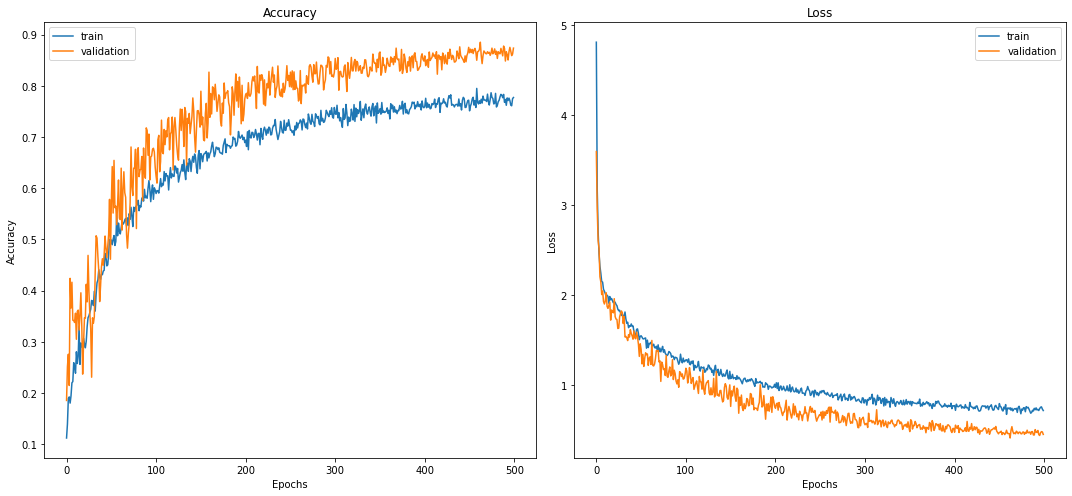

In [21]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


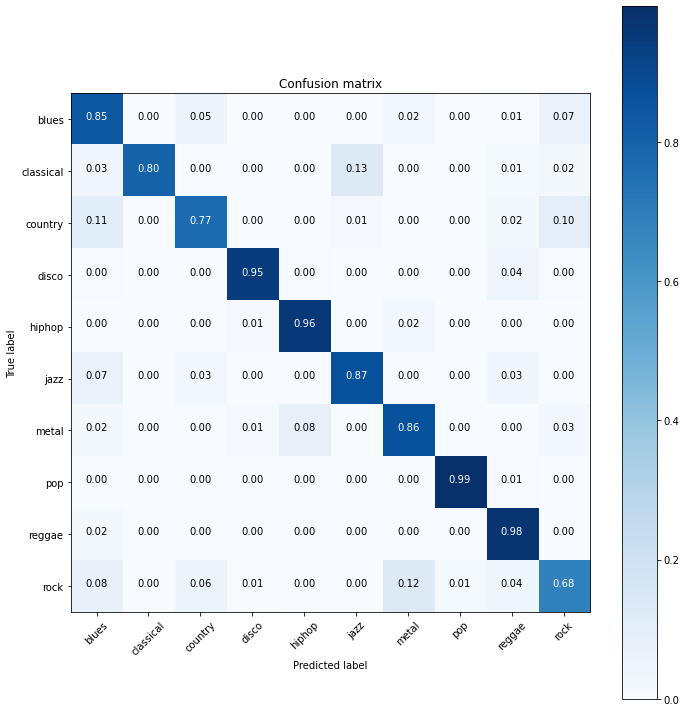

In [24]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

In [25]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [26]:
preds = model.predict(X_test, batch_size=128, verbose=0)

In [27]:
# Each sound was divided into 39 segments in our custom function
scores_songs = np.split(np.argmax(preds, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]

In [28]:
# Same analysis for split
label = np.split(np.argmax(y_test, axis=1), 300)
label = [majority_vote(l) for l in label]

In [29]:
from sklearn.metrics import accuracy_score

print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))

majority voting system (acc) = 0.903


In [30]:
# Save the model
model.save('custom_cnn1_2d.h5')